<a href="https://colab.research.google.com/github/Flychuban/Read-data-from-image/blob/main/ReadTable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!add-apt-repository -y ppa:alex-p/tesseract-ocr-devel
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:7 http://ppa.launchpad.net/alex-p/tesseract-ocr-devel/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.co

In [48]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

Function to display images in Jupyter Notebooks and Google Colab

In [49]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

Implementing Multi-Column Table OCR

In [50]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image to be OCR'd")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output CSV file")
# ap.add_argument("-c", "--min-conf", type=int, default=0,
# 	help="minimum confidence value to filter weak text detection")
# ap.add_argument("-d", "--dist-thresh", type=float, default=25.0,
# 	help="distance threshold cutoff for clustering")
# ap.add_argument("-s", "--min-size", type=int, default=2,
# 	help="minimum cluster size (i.e., # of entries in column)")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values # michael_jordan_stats.png # atevH.jpg
args = {
	"image": "/content/drive/MyDrive/ReadDataImage/page0.jpg",
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 10.0,
	"min_size": 2,
}

In [125]:
# set a seed for our random number generator
np.random.seed(42)

# load the input image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

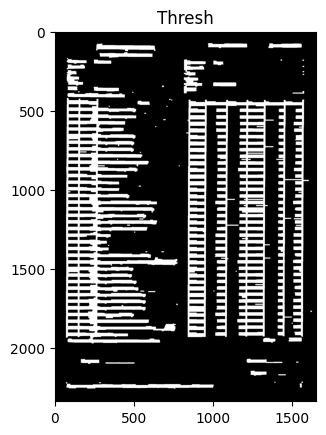

In [126]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

# apply a closing operation using the rectangular kernel to close
# gaps in between characters, apply Otsu's thresholding method, and
# finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt_imshow("Thresh", thresh)

<ipython-input-135-ca66134466b4>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cnts.remove(tableCnt)


[[[1563  433]]

 [[1563  434]]

 [[1562  435]]

 ...

 [[1570  443]]

 [[1571  442]]

 [[1571  433]]]


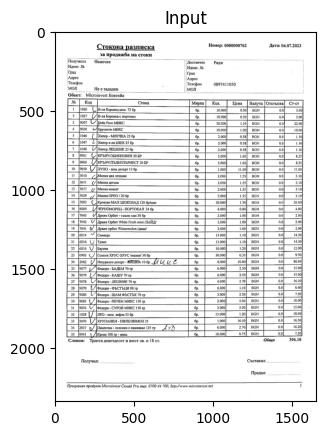

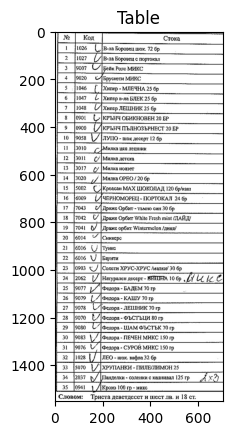

In [135]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = list(cnts)
tableCnt = max(cnts, key=cv2.contourArea)
cnts.remove(tableCnt)
tableCnt2 = max(cnts, key=cv2.contourArea)
print(tableCnt)


# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt2)
table = image[y:y + h, x:x + w]

# show the original input image and extracted table to our screen
plt_imshow("Input", image)
plt_imshow("Table", table)